In [1]:
import torch
import numpy as np
import os 
import inspect
import sys
import time
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
parentdir = os.path.dirname(parentdir)
sys.path.insert(0, parentdir) 

from utils import set_seed, query_environment_info, read_config_from_yaml
from model import  Quad_Value_Net, Policy,WaveFunction_Koopman_dynamics
from solver import create_solver
from roll_out import roll_out
from dataset import RLDataset
import controlgym as gym
from controlgym.helpers.plotting import _plot_coupled_pde
import matplotlib.pyplot as plt


torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True
set_seed(2024)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = read_config_from_yaml("training_scripts/wave/config.yaml")

[INFO] Setting the seed to 2024
[INFO] Loaded data from training_scripts/wave/config.yaml


In [2]:
# Create environment
env_name = config["env_name"]
process_noise_cov = config["process_noise_cov"]
sensor_noise_cov = config["sensor_noise_cov"]
n_state = config["n_state"]
n_obs = config["n_observation"]
n_action = config["n_action"]
observation_limit = config["observation_limit"]
action_limit = config["action_limit"]
R_weight = config["R_weight"]
Q_weight = config["Q_weight"]
env = gym.make(env_name, process_noise_cov=process_noise_cov, 
                         sensor_noise_cov=sensor_noise_cov,
                         n_state=n_state, n_observation=n_obs, n_action=n_action,
                         action_limit=action_limit, 
                         observation_limit=observation_limit,
                         R_weight=R_weight, 
                         Q_weight=Q_weight)
env.n_steps = config["eval_T"]
env_info = query_environment_info(env, env_name)
state_dim = env.observation_space.shape[0] 
act_dim = env.action_space.shape[0]

[INFO] Creating the environment: <WaveEnv instance>
Name: wave
Action Space: Box(-1.0, 1.0, (10,), float64)
Observation Space: Box(-10.0, 10.0, (50,), float64)
Reward Range: (-1000000000000000.0, 1000000000000000.0)



In [3]:
# Construct and Load Model
save_path = "trained_weights"
num_steps = config["num_steps"]
hidden_dim = config["hidden_dim"]

pos_dim = int(state_dim/2)
velocity_dim = int(state_dim/2)

Kdys_model = WaveFunction_Koopman_dynamics(pos_dim=pos_dim, velocity_dim=velocity_dim,hidden_dim=hidden_dim, act_dim=act_dim, num_steps=num_steps).to(device)
Kdys_model.load_state_dict(torch.load(save_path + '/KoopmanDynamics.pt', map_location=torch.device('cpu')))
Kz = torch.load(save_path + '/Kz.pt', map_location=torch.device('cpu'))
Jz_B = torch.load(save_path + '/Jz_B.pt', map_location=torch.device('cpu'))
Kdys_model.koopman.Kz = Kz.to(device)
Kdys_model.koopman.Jz_B = Jz_B.to(device)
Kdys_model.to(device)

WaveFunction_Koopman_dynamics(
  (koopman): KoopmanOp()
  (encoder): WaveFunctionEncoder(
    (position_enocder): Sequential(
      (0): Linear(in_features=25, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): Tanh()
      (4): Linear(in_features=32, out_features=32, bias=True)
      (5): Tanh()
    )
    (velocity_encoder): Sequential(
      (0): Linear(in_features=25, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): Tanh()
      (4): Linear(in_features=32, out_features=32, bias=True)
      (5): Tanh()
    )
    (joint_encoder): Linear(in_features=64, out_features=64, bias=True)
  )
  (decoder): WaveFunctionDecoder(
    (joint_decoder): Linear(in_features=64, out_features=64, bias=True)
    (position_decoder): Sequential(
      (0): Tanh()
      (1): Linear(in_features=32, out_features=32, bias=True)
      (2): Tanh()
      (3): Linear(in_features=

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 212.59it/s]


(8, 50)


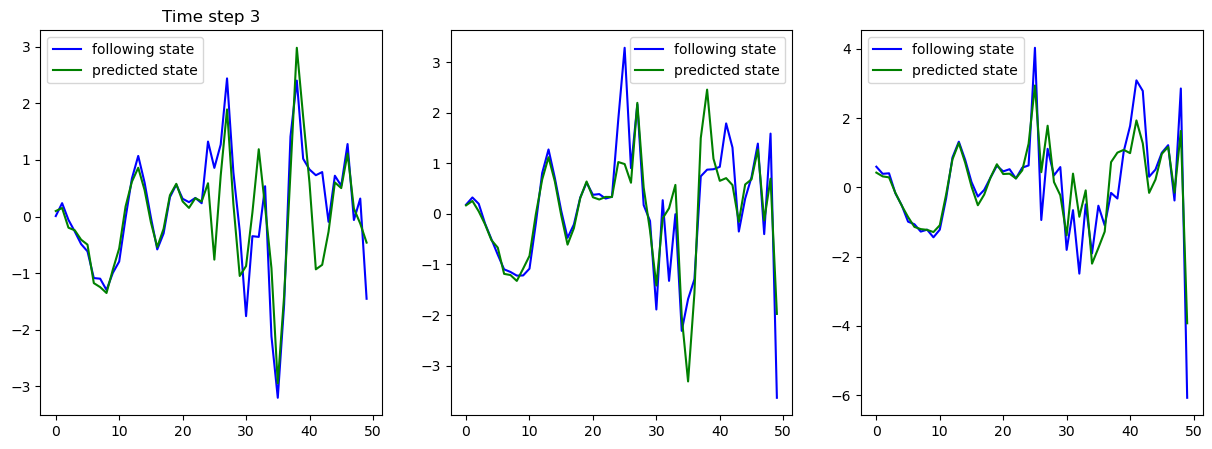

In [4]:
## Evaluate the predicition of the Koopman Dynamics
roll_out_sampler = roll_out(env, env_info)
num_trajactories=10
max_time_step=20
for i in range(1):
    test_buffer = roll_out_sampler.roll_out_sampler_with_env(num_trajactories=num_trajactories,
                                                             max_time_step=max_time_step, random_action=True)
    test_dataset = RLDataset(num_steps, state_dim, act_dim, 
                             state_hidden_dim=hidden_dim, 
                             act_hidden_dim=8, 
                             sample_traj_length=max_time_step, 
                             capacity=num_trajactories*(max_time_step-num_steps-1))
    test_dataset.obtain_data_from_obs_buffer(test_buffer)

j = np.random.randint(0, num_trajactories)
initial_states, actions, following_states, rewards, dones = test_dataset.__getitem__(j)

pred_next_states = []
for i in range(num_steps):
    state = initial_states[i].to(device).unsqueeze(0)
    action = actions[i].to(device).unsqueeze(0)
    
    next_state = Kdys_model(state, action).squeeze(0).detach().cpu().numpy()
    pred_next_states.append(next_state)

pred_next_states = np.array(pred_next_states)
print(pred_next_states.shape)
n_half_state_dim = state_dim 
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].plot(following_states[1, :n_half_state_dim], c="b", label='following state')
axes[0].plot(pred_next_states[1, :n_half_state_dim], c="g", label='predicted state')
axes[0].set_title("Time step 1")
axes[0].legend()
axes[1].plot(following_states[2, :n_half_state_dim], c="b", label='following state')
axes[1].plot(pred_next_states[2, :n_half_state_dim], c="g", label='predicted state')
axes[0].set_title("Time step 2")
axes[1].legend()
axes[2].plot(following_states[3, :n_half_state_dim], c="b", label='following state')
axes[2].plot(pred_next_states[3, :n_half_state_dim], c="g", label='predicted state')
axes[0].set_title("Time step 3")
axes[2].legend()
plt.show()

In [5]:
value_net = Quad_Value_Net(hidden_dim).to(device)
value_net.load_state_dict(torch.load(save_path + '/Quad_Value_Net.pt', map_location=torch.device('cpu')))


solver = create_solver(env_info)()
policy = Policy(solver)

[INFO] Cretateing the Solver for wave


In [ ]:
# Start Evaluation
eval_T = config["eval_T"]
eval_episodes = config["eval_episodes"]
eval_rewards = [[] for i in range(eval_episodes)]
eval_time = np.zeros(eval_episodes//10)
eval_traj = np.zeros((eval_episodes, eval_T+1, state_dim))
eval_traj_obs = np.zeros((eval_episodes, eval_T+1, state_dim))
eval_actions = np.zeros((eval_episodes, eval_T+1, act_dim))


for n in range(eval_episodes):
    
    test_init_state = env.state[:25] + np.random.normal(0, 0.01, 25)
    test_init_state = np.concatenate((test_init_state, np.zeros(25))) 

    env_test = gym.make(env_name, process_noise_cov=process_noise_cov, 
                        sensor_noise_cov=sensor_noise_cov,
                        n_state=n_state, n_observation=n_obs, n_action=n_action,
                        action_limit=action_limit, 
                        observation_limit=observation_limit,
                        Q_weight=Q_weight,
                        R_weight=R_weight)
    env_test.n_steps = config["eval_T"]
    start_time = time.time()
    t = 0
    state = env_test.reset()[0]
    eval_traj_obs[n, t, :] = state
    eval_traj[n, t, :] = env_test.state
    while t < eval_T:
        t += 1

        state = torch.tensor(state, dtype=torch.float32).to(device).unsqueeze(0)
        action = policy.select_actions(Kdys_model, value_net, state, if_batch=False).detach().cpu().numpy()

        eval_traj_obs[n, t, :] = state.detach().cpu().numpy()
        eval_actions[n, t, :] = action
        next_state, reward, done, _, _ = env_test.step(action)
        eval_rewards[n].append(reward)
        state = next_state
        
        eval_traj[n, t, :] = env_test.state
        
        if done:
            break
    end_time = time.time()
    if n%10 == 0:
        eval_time[n//10] = end_time-start_time 
    else: 
        eval_time[n//10] += end_time-start_time
    print("Test Episode:", n, " Reward:", np.sum(eval_rewards[n]), "Time:", end_time-start_time)

Test Episode: 0  Reward: -217.33537664872915 Time: 0.6219000816345215
Test Episode: 1  Reward: -166.93655646404045 Time: 0.6005020141601562
Test Episode: 2  Reward: -182.74341088960801 Time: 0.5951690673828125
Test Episode: 3  Reward: -169.70893547216963 Time: 0.6050980091094971
Test Episode: 4  Reward: -155.24662059586439 Time: 0.5841238498687744
Test Episode: 5  Reward: -140.9402485051419 Time: 0.565140962600708
Test Episode: 6  Reward: -128.12669980274615 Time: 0.5677790641784668
Test Episode: 7  Reward: -165.87755403614628 Time: 0.558121919631958
Test Episode: 8  Reward: -147.29919830829306 Time: 0.5974838733673096
Test Episode: 9  Reward: -183.12170275813327 Time: 0.609004020690918
Test Episode: 10  Reward: -159.01923751962585 Time: 0.5932748317718506
Test Episode: 11  Reward: -197.74130754280338 Time: 0.5702059268951416
Test Episode: 12  Reward: -203.6520551745807 Time: 0.591728925704956
Test Episode: 13  Reward: -234.7975435698405 Time: 0.6049108505249023
Test Episode: 14  Rewar

In [ ]:
env_test.state_traj = eval_traj[0].T

eval_rewards = np.array(eval_rewards)
print("Mean Reward: ", np.mean(np.sum(eval_rewards, axis=1)))
print("Std Reward: ", np.std(np.sum(eval_rewards, axis=1)))
print("Mean Time: ", np.mean(eval_time))
print("Std Time: ", np.std(eval_time))

save_eval_path = "eval_results"
if not os.path.exists(save_eval_path):
    os.makedirs(save_eval_path)
save_eval_path = save_eval_path + "/" + "{}".format(env_name)
if not os.path.exists(save_eval_path):
    os.makedirs(save_eval_path)
    
np.save(save_eval_path + "/" + "eval_traj.npy", eval_traj)
np.save(save_eval_path + "/" + "eval_actions.npy", eval_actions)
np.save(save_eval_path + "/" + "eval_rewards.npy", eval_rewards)

Mean Reward:  -169.13822927325367
Std Reward:  27.262155891131318
Mean Time:  0.5582081437110901
Std Time:  0.018814058439298877


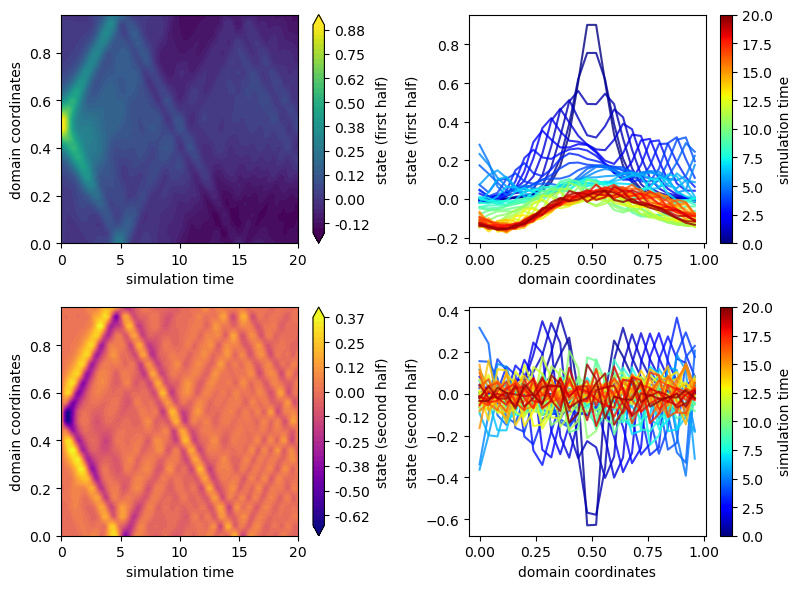

In [8]:
_plot_coupled_pde(env_test, save_eval_path, display=True, surface3d=False)

### Using Linear Quadratic Control 

In [ ]:
from koopman_lqr import Koopman_LQR

In [17]:
eval_rewards_lqr = np.zeros(eval_episodes)
eval_time_lqr = np.zeros(eval_episodes)
for n in range(eval_episodes):
    env_test = gym.make(env_name, process_noise_cov=process_noise_cov, 
                    sensor_noise_cov=sensor_noise_cov,
                    n_state=n_state, n_observation=n_obs, n_action=n_action,
                    action_limit=action_limit, 
                    observation_limit=observation_limit,
                    Q_weight=Q_weight,
                    R_weight=R_weight)
    env_test.n_steps = config["eval_T"]
    koopman_controller = Koopman_LQR(env_test, Kdys_model, Q_coe=1, R_coe=1)


    test_init_state = env.state[:25] + np.random.normal(0, 0.01, 25)
    test_init_state = np.concatenate((test_init_state, np.zeros(25))) 
    start_time = time.time()
    total_reward = koopman_controller.run(test_init_state)
    end_time = time.time()
    eval_rewards_lqr[n] = total_reward
    eval_time_lqr[n] = end_time-start_time
    print("Test Episode:", n, " Reward:", total_reward, "Time:", eval_time_lqr[n])

print("Mean Reward Koopman LQR: ", np.mean(eval_rewards_lqr))
print("Std Reward Koopman LQR: ", np.std(eval_rewards_lqr))
print("Mean Time Koopman LQR: ", np.mean(eval_time_lqr))
print("Std Time Koopman LQR: ", np.std(eval_time_lqr))
   

Test Episode: 0  Reward: -61317.62099132361 Time: 0.05932807922363281
Test Episode: 1  Reward: -60247.92763277938 Time: 0.05917787551879883
Test Episode: 2  Reward: -29318.425507522912 Time: 0.054540157318115234
Test Episode: 3  Reward: -105729.30725058941 Time: 0.06033682823181152
Test Episode: 4  Reward: -14144.083117939914 Time: 0.05452084541320801
Test Episode: 5  Reward: -14819.750620781286 Time: 0.0612337589263916
Test Episode: 6  Reward: -92122.5161524925 Time: 0.0625920295715332
Test Episode: 7  Reward: -15686.519909014181 Time: 0.0636451244354248
Test Episode: 8  Reward: -96773.9031325977 Time: 0.06001114845275879
Test Episode: 9  Reward: -63487.872214172974 Time: 0.06141996383666992
Test Episode: 10  Reward: -54341.22589833164 Time: 0.0582118034362793
Test Episode: 11  Reward: -18044.60855138552 Time: 0.05864977836608887
Test Episode: 12  Reward: -23421.42461293019 Time: 0.05729484558105469
Test Episode: 13  Reward: -16243.2558386651 Time: 0.058190107345581055
Test Episode: 1

KeyboardInterrupt: 

In [9]:
from Koopman_QP import Koopman_MPC_QP

In [ ]:
eval_rewards_qp = np.zeros(eval_episodes)
eval_time_qp = np.zeros(eval_episodes//10)
for i in range(eval_episodes):
    env_test = gym.make(env_name, process_noise_cov=process_noise_cov, 
                    sensor_noise_cov=sensor_noise_cov,
                    n_state=n_state, n_observation=n_obs, n_action=n_action,
                    action_limit=action_limit, 
                    observation_limit=observation_limit,
                    Q_weight=Q_weight,
                    R_weight=R_weight)
    env_test.n_steps = config["eval_T"]
    mpc_controllor = Koopman_MPC_QP(env, Kdys_model)
    
    start_time = time.time()
    reward, state_traj, action_traj = mpc_controllor.perform_MPC(H=env.n_steps-1)
    end_time = time.time()
    
    eval_rewards_qp[i] = np.sum(reward)
    if n%10 == 0:
        eval_time_qp[n//10] = end_time-start_time 
    else: 
        eval_time_qp[n//10] += end_time-start_time

    print("Test Episode:", i, " Reward:", eval_rewards_qp[i], "Time:", end_time-start_time)



Performing Koopman MPC: 100%|██████████| 199/199 [00:03<00:00, 65.47it/s]


Test Episode: 0  Reward: -426.8622340092595 Time: 3.0412957668304443


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 69.54it/s]


Test Episode: 1  Reward: -427.5399968534631 Time: 2.8628437519073486


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 70.04it/s]


Test Episode: 2  Reward: -496.9466313312412 Time: 2.842524290084839


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 70.29it/s]


Test Episode: 3  Reward: -508.30001977024097 Time: 2.832289695739746


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 70.61it/s]


Test Episode: 4  Reward: -477.978127561257 Time: 2.8196170330047607


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.50it/s]


Test Episode: 5  Reward: -370.8116383993533 Time: 2.949338912963867


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 69.49it/s]


Test Episode: 6  Reward: -530.0561129156456 Time: 2.8651959896087646


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 69.52it/s]


Test Episode: 7  Reward: -417.2994491153733 Time: 2.863758087158203


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.91it/s]


Test Episode: 8  Reward: -547.0581890008846 Time: 2.9313700199127197


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 69.65it/s]


Test Episode: 9  Reward: -444.5870038581878 Time: 2.858570098876953


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 69.41it/s]


Test Episode: 10  Reward: -571.5346576062743 Time: 2.8683018684387207


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 70.30it/s]


Test Episode: 11  Reward: -403.2461523249673 Time: 2.8321919441223145


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.97it/s]


Test Episode: 12  Reward: -517.6744991061335 Time: 2.7662220001220703


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 70.86it/s]


Test Episode: 13  Reward: -433.1349649028158 Time: 2.8095250129699707


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 70.48it/s]


Test Episode: 14  Reward: -376.29154194354317 Time: 2.8247969150543213


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 70.29it/s]


Test Episode: 15  Reward: -427.0052667160912 Time: 2.8322577476501465


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.75it/s]


Test Episode: 16  Reward: -494.64973917342644 Time: 2.8964288234710693


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.23it/s]


Test Episode: 17  Reward: -488.68942159036067 Time: 2.961413860321045


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 69.91it/s]


Test Episode: 18  Reward: -553.7564207486323 Time: 2.8477060794830322


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.42it/s]


Test Episode: 19  Reward: -415.26088117277163 Time: 2.9101040363311768


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.41it/s]


Test Episode: 20  Reward: -528.4329581961061 Time: 2.9103379249572754


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.18it/s]


Test Episode: 21  Reward: -433.9312141471303 Time: 2.9202442169189453


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.32it/s]


Test Episode: 22  Reward: -427.60820591671694 Time: 2.9142279624938965


Performing Koopman MPC: 100%|██████████| 199/199 [00:03<00:00, 65.87it/s]


Test Episode: 23  Reward: -560.7584688965671 Time: 3.023013114929199


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.81it/s]


Test Episode: 24  Reward: -537.823121137502 Time: 2.9367661476135254


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.03it/s]


Test Episode: 25  Reward: -536.1968383533488 Time: 2.9266068935394287


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.40it/s]


Test Episode: 26  Reward: -422.2495855794332 Time: 2.9104831218719482


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 67.86it/s]


Test Episode: 27  Reward: -368.65616900579175 Time: 2.933695077896118


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 68.47it/s]


Test Episode: 28  Reward: -459.0665475379225 Time: 2.9075000286102295


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 69.80it/s]


Test Episode: 29  Reward: -381.7892375419916 Time: 2.852099895477295


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 69.54it/s]


Test Episode: 30  Reward: -397.89947560137784 Time: 2.8626348972320557


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 70.75it/s]


Test Episode: 31  Reward: -530.051065499409 Time: 2.8137660026550293


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 69.55it/s]


Test Episode: 32  Reward: -540.0947262549975 Time: 2.8623831272125244


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 72.21it/s]


Test Episode: 33  Reward: -414.3654962465996 Time: 2.7572739124298096


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.08it/s]


Test Episode: 34  Reward: -460.1340068227462 Time: 2.80112886428833


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 70.13it/s]


Test Episode: 35  Reward: -495.4991572072363 Time: 2.8386199474334717


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 72.24it/s]


Test Episode: 36  Reward: -538.9571335222272 Time: 2.7559680938720703


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 72.03it/s]


Test Episode: 37  Reward: -556.0632423344599 Time: 2.7637131214141846


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 72.05it/s]


Test Episode: 38  Reward: -402.94843980371854 Time: 2.7631969451904297


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 72.45it/s]


Test Episode: 39  Reward: -534.1982338180234 Time: 2.7478389739990234


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 70.65it/s]


Test Episode: 40  Reward: -445.06746000925796 Time: 2.8178763389587402


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 72.04it/s]


Test Episode: 41  Reward: -414.80164138427244 Time: 2.7636122703552246


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 72.32it/s]


Test Episode: 42  Reward: -381.22820201251096 Time: 2.7526769638061523


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 70.08it/s]


Test Episode: 43  Reward: -455.2294684775651 Time: 2.841066837310791


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.58it/s]


Test Episode: 44  Reward: -452.84135072818185 Time: 2.781564950942993


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.27it/s]


Test Episode: 45  Reward: -552.5143496471744 Time: 2.793353796005249


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 72.14it/s]


Test Episode: 46  Reward: -515.0119003575625 Time: 2.7596023082733154


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.94it/s]


Test Episode: 47  Reward: -427.7629426403852 Time: 2.7677900791168213


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.87it/s]


Test Episode: 48  Reward: -478.3208601186168 Time: 2.77007794380188


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 69.92it/s]


Test Episode: 49  Reward: -357.03619760420884 Time: 2.8474812507629395


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.90it/s]


Test Episode: 50  Reward: -437.20045301815065 Time: 2.769011974334717


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 72.18it/s]


Test Episode: 51  Reward: -523.1975805300805 Time: 2.7581801414489746


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 70.14it/s]


Test Episode: 52  Reward: -404.9677737643364 Time: 2.838301181793213


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.98it/s]


Test Episode: 53  Reward: -453.86301498555804 Time: 2.766374349594116


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.29it/s]


Test Episode: 54  Reward: -533.2088776203788 Time: 2.79252290725708


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 72.09it/s]


Test Episode: 55  Reward: -422.3702337620949 Time: 2.76159405708313


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 72.06it/s]


Test Episode: 56  Reward: -414.2691001165308 Time: 2.762963056564331


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 72.00it/s]


Test Episode: 57  Reward: -410.90442471543406 Time: 2.7650868892669678


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 69.65it/s]


Test Episode: 58  Reward: -506.9323938019138 Time: 2.8582592010498047


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.98it/s]


Test Episode: 59  Reward: -496.28392380321 Time: 2.765861988067627


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.89it/s]


Test Episode: 60  Reward: -441.1759096307818 Time: 2.7697529792785645


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 70.38it/s]


Test Episode: 61  Reward: -463.3750743589593 Time: 2.8290059566497803


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.52it/s]


Test Episode: 62  Reward: -533.0685477794934 Time: 2.783651828765869


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.28it/s]


Test Episode: 63  Reward: -486.03585586985196 Time: 2.793052911758423


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.90it/s]


Test Episode: 64  Reward: -531.5390266436159 Time: 2.7688281536102295


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.87it/s]


Test Episode: 65  Reward: -366.5065907307521 Time: 2.7701029777526855


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.46it/s]


Test Episode: 66  Reward: -543.7846956552826 Time: 2.7862467765808105


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 69.01it/s]


Test Episode: 67  Reward: -366.1239616283669 Time: 2.8852379322052


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.80it/s]


Test Episode: 68  Reward: -399.52118775640275 Time: 2.772461175918579


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.75it/s]


Test Episode: 69  Reward: -528.6783115965413 Time: 2.7746047973632812


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 70.34it/s]


Test Episode: 70  Reward: -489.84043094791843 Time: 2.8303778171539307


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.35it/s]


Test Episode: 71  Reward: -419.23770260664594 Time: 2.7902960777282715


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.50it/s]


Test Episode: 72  Reward: -468.1150129947697 Time: 2.784548044204712


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.94it/s]


Test Episode: 73  Reward: -389.7744358509489 Time: 2.767611265182495


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 72.09it/s]


Test Episode: 74  Reward: -449.6329575794118 Time: 2.76159405708313


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 70.45it/s]


Test Episode: 75  Reward: -493.66194001304797 Time: 2.8258109092712402


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.12it/s]


Test Episode: 76  Reward: -532.9114017706971 Time: 2.799266815185547


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 70.17it/s]


Test Episode: 77  Reward: -492.96653829328676 Time: 2.8372368812561035


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 70.10it/s]


Test Episode: 78  Reward: -540.694602442059 Time: 2.8398971557617188


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.36it/s]


Test Episode: 79  Reward: -444.7964102993401 Time: 2.790212631225586


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 70.90it/s]


Test Episode: 80  Reward: -450.05793959200724 Time: 2.808432102203369


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.74it/s]


Test Episode: 81  Reward: -509.8933152878772 Time: 2.7750473022460938


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.68it/s]


Test Episode: 82  Reward: -505.70860649839165 Time: 2.777423143386841


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.69it/s]


Test Episode: 83  Reward: -426.71919684171377 Time: 2.7768867015838623


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 69.78it/s]


Test Episode: 84  Reward: -440.1140955125339 Time: 2.8529751300811768


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.88it/s]


Test Episode: 85  Reward: -438.1267758835801 Time: 2.769761085510254


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.55it/s]


Test Episode: 86  Reward: -407.7802706854259 Time: 2.7823801040649414


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 69.78it/s]


Test Episode: 87  Reward: -428.99259499835006 Time: 2.852783203125


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.75it/s]


Test Episode: 88  Reward: -384.8233726222617 Time: 2.7747371196746826


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 70.66it/s]


Test Episode: 89  Reward: -495.2763855131781 Time: 2.817305088043213


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.24it/s]


Test Episode: 90  Reward: -461.2835939128115 Time: 2.7946131229400635


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.16it/s]


Test Episode: 91  Reward: -496.96986595013743 Time: 2.7981741428375244


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 70.77it/s]


Test Episode: 92  Reward: -466.6117673978652 Time: 2.81357741355896


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 69.12it/s]


Test Episode: 93  Reward: -453.7059957942202 Time: 2.8805370330810547


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.25it/s]


Test Episode: 94  Reward: -359.8483242047447 Time: 2.794354200363159


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.60it/s]


Test Episode: 95  Reward: -513.701077800798 Time: 2.780794858932495


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 69.35it/s]


Test Episode: 96  Reward: -480.58752196903487 Time: 2.8707339763641357


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 70.39it/s]


Test Episode: 97  Reward: -404.97502379483353 Time: 2.8282570838928223


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.29it/s]


Test Episode: 98  Reward: -475.2739333031082 Time: 2.7924790382385254


Performing Koopman MPC: 100%|██████████| 199/199 [00:02<00:00, 71.48it/s]

Test Episode: 99  Reward: -424.9208594987006 Time: 2.7854812145233154


In [12]:
print("Mean Reward Koopman MPC QP: ", np.mean(eval_rewards_qp))
print("Std Reward Koopman MPC QP: ", np.std(eval_rewards_qp))
print("Mean Time Koopman MPC QP: ", np.mean(eval_time_qp))
print("Std Time Koopman MPC QP: ", np.std(eval_time_qp))

Mean Reward Koopman MPC QP:  -463.45229532130395
Std Reward Koopman MPC QP:  55.90642566612396
Mean Time Koopman MPC QP:  2.82437038898468
Std Time Koopman MPC QP:  0.0609558078456756
